# **Imports**

In [1]:
import pandas as pd
import numpy as np
import zipfile
import os
import glob
import matplotlib.pyplot as plt


# **Set ZIP Paths**

In [2]:
enrol_zip_path = "/content/api_data_aadhar_enrolment.zip"
demo_zip_path  = "/content/api_data_aadhar_demographic.zip"
bio_zip_path   = "/content/api_data_aadhar_biometric.zip"


# **Extract ZIP Files**

In [3]:
def extract_zip(zip_path, extract_to):
    os.makedirs(extract_to, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(extract_to)
    print(f"Extracted {zip_path} -> {extract_to}")

extract_zip(enrol_zip_path, "/content/enrolment")
extract_zip(demo_zip_path,  "/content/demographic")
extract_zip(bio_zip_path,   "/content/biometric")


Extracted /content/api_data_aadhar_enrolment.zip -> /content/enrolment
Extracted /content/api_data_aadhar_demographic.zip -> /content/demographic
Extracted /content/api_data_aadhar_biometric.zip -> /content/biometric


# **Load All CSVs from Folder**

In [4]:
def load_all_csvs(folder):
    csv_files = glob.glob(os.path.join(folder, "**/*.csv"), recursive=True)
    if len(csv_files) == 0:
        raise ValueError(f"No CSV files found in: {folder}")

    dfs = []
    for f in csv_files:
        df = pd.read_csv(f)
        dfs.append(df)

    final = pd.concat(dfs, ignore_index=True)
    print(f"Loaded {len(csv_files)} CSVs from {folder} -> shape: {final.shape}")
    return final

enrol_df = load_all_csvs("/content/enrolment")
demo_df  = load_all_csvs("/content/demographic")
bio_df   = load_all_csvs("/content/biometric")


Loaded 3 CSVs from /content/enrolment -> shape: (1006029, 7)
Loaded 5 CSVs from /content/demographic -> shape: (2071700, 6)
Loaded 4 CSVs from /content/biometric -> shape: (1861108, 6)


# **Clean Column Names + Validate Keys**

In [5]:
def clean_columns(df):
    df = df.copy()
    df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
    return df

enrol_df = clean_columns(enrol_df)
demo_df  = clean_columns(demo_df)
bio_df   = clean_columns(bio_df)

common_keys = ["date", "state", "district", "pincode"]

def validate_keys(df, name):
    missing = [k for k in common_keys if k not in df.columns]
    if missing:
        raise ValueError(f"{name} is missing keys: {missing}")
    print(f"{name} keys OK ✅")

validate_keys(enrol_df, "Enrolment")
validate_keys(demo_df, "Demographic")
validate_keys(bio_df, "Biometric")


Enrolment keys OK ✅
Demographic keys OK ✅
Biometric keys OK ✅


# **Preprocess Base Fields (Date + Text Cleanup)**

In [6]:
def preprocess_base(df):
    df = df.copy()

    df["date"] = pd.to_datetime(df["date"], errors="coerce")

    df["state"] = df["state"].astype(str).str.strip()
    df["district"] = df["district"].astype(str).str.strip()
    df["pincode"] = df["pincode"].astype(str).str.strip()

    # remove invalid rows
    df = df.dropna(subset=["date"])
    df = df[df["state"].notna() & (df["state"] != "nan")]
    df = df[df["district"].notna() & (df["district"] != "nan")]
    df = df[df["pincode"].notna() & (df["pincode"] != "nan")]

    return df

enrol_df = preprocess_base(enrol_df)
demo_df  = preprocess_base(demo_df)
bio_df   = preprocess_base(bio_df)

print("Shapes after preprocess:")
print("Enrol:", enrol_df.shape)
print("Demo :", demo_df.shape)
print("Bio  :", bio_df.shape)


/tmp/ipython-input-1923790375.py:4: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["date"] = pd.to_datetime(df["date"], errors="coerce")
/tmp/ipython-input-1923790375.py:4: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["date"] = pd.to_datetime(df["date"], errors="coerce")


Shapes after preprocess:
Enrol: (1006029, 7)
Demo : (2071700, 6)
Bio  : (917008, 6)


# **Convert Numeric Columns**

In [7]:
def convert_numeric_except_keys(df):
    df = df.copy()
    for c in df.columns:
        if c not in common_keys:
            df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)
    return df

enrol_df = convert_numeric_except_keys(enrol_df)
demo_df  = convert_numeric_except_keys(demo_df)
bio_df   = convert_numeric_except_keys(bio_df)


# **Aggregate Duplicates (Safe Merge)**

In [8]:
def aggregate_duplicates(df):
    num_cols = [c for c in df.columns if c not in common_keys]
    df = df.groupby(common_keys, as_index=False)[num_cols].sum()
    return df

enrol_df = aggregate_duplicates(enrol_df)
demo_df  = aggregate_duplicates(demo_df)
bio_df   = aggregate_duplicates(bio_df)

print("After aggregation:")
print(enrol_df.shape, demo_df.shape, bio_df.shape)


After aggregation:
(983072, 7) (1598099, 6) (871964, 6)


# **Merge All 3 Datasets**

In [9]:
merged = enrol_df.merge(demo_df, on=common_keys, how="outer")
merged = merged.merge(bio_df, on=common_keys, how="outer")
merged = merged.fillna(0)

print("Merged shape:", merged.shape)
merged.head()


Merged shape: (2638324, 11)


,date,state,district,pincode,age_0_5,age_5_17,age_18_greater,demo_age_5_17,demo_age_17_,bio_age_5_17,bio_age_17_
0,2025-01-03,Andaman & Nicobar Islands,Andamans,744101,0.0,0.0,0.0,0.0,0.0,16.0,193.0
1,2025-01-03,Andaman and Nicobar Islands,Nicobar,744301,0.0,0.0,0.0,0.0,0.0,101.0,48.0
2,2025-01-03,Andaman and Nicobar Islands,Nicobar,744302,0.0,0.0,0.0,0.0,0.0,15.0,12.0
3,2025-01-03,Andaman and Nicobar Islands,Nicobar,744303,0.0,0.0,0.0,0.0,0.0,46.0,27.0
4,2025-01-03,Andaman and Nicobar Islands,Nicobar,744304,0.0,0.0,0.0,0.0,0.0,16.0,14.0


# **Feature Engineering (Stress + Ratios)**

In [10]:
# Total enrolments
merged["total_enrolments"] = (
    merged.get("age_0_5", 0) +
    merged.get("age_5_17", 0) +
    merged.get("age_18_greater", 0)
)

# Total updates
merged["total_demo_updates"] = (
    merged.get("demo_age_5_17", 0) +
    merged.get("demo_age_17_", 0)
)

merged["total_bio_updates"] = (
    merged.get("bio_age_5_17", 0) +
    merged.get("bio_age_17_", 0)
)

merged["total_updates"] = merged["total_demo_updates"] + merged["total_bio_updates"]

# Ratio
merged["update_to_enrol_ratio"] = np.where(
    merged["total_enrolments"] > 0,
    merged["total_updates"] / merged["total_enrolments"],
    0
)

# Stress Index (updates are heavier workload)
merged["service_stress_index"] = (0.6 * merged["total_updates"]) + (0.4 * merged["total_enrolments"])


# **Data Quality Signals (Anomaly Detection)**

In [11]:
merged = merged.sort_values(["pincode", "date"])

merged["stress_rolling_mean_7"] = merged.groupby("pincode")["service_stress_index"].transform(
    lambda x: x.rolling(7, min_periods=3).mean()
)

merged["stress_rolling_std_7"] = merged.groupby("pincode")["service_stress_index"].transform(
    lambda x: x.rolling(7, min_periods=3).std()
).fillna(0)

merged["stress_zscore"] = np.where(
    merged["stress_rolling_std_7"] > 0,
    (merged["service_stress_index"] - merged["stress_rolling_mean_7"]) / merged["stress_rolling_std_7"],
    0
)

merged["anomaly_flag"] = np.where(merged["stress_zscore"] >= 3, 1, 0)


# **RESULTS + FINDINGS**

# A) Top 15 District Hotspots (Highest Stress)

In [12]:
district_hotspots = (merged.groupby(["state", "district"], as_index=False)
                     .agg(
                         total_stress=("service_stress_index", "sum"),
                         total_enrolments=("total_enrolments", "sum"),
                         total_updates=("total_updates", "sum"),
                         anomaly_count=("anomaly_flag", "sum")
                     )
                     .sort_values("total_stress", ascending=False)
                     .head(15))

district_hotspots


,state,district,total_stress,total_enrolments,total_updates,anomaly_count
576,Maharashtra,Pune,556533.8,31763.0,906381.0,0
585,Maharashtra,Thane,539786.0,43688.0,870518.0,0
572,Maharashtra,Nashik,415133.4,22368.0,676977.0,0
241,Gujarat,Ahmedabad,375968.0,19130.0,613860.0,0
273,Gujarat,Surat,365978.0,25469.0,592984.0,0
1104,West Bengal,South 24 Parganas,362509.8,33540.0,581823.0,0
229,Delhi,North West Delhi,361638.8,16043.0,592036.0,0
797,Rajasthan,Jaipur,347617.8,31146.0,558599.0,0
1089,West Bengal,Murshidabad,342664.0,35911.0,547166.0,0
408,Karnataka,Bengaluru,339626.0,30980.0,545390.0,0


# B) Top 15 Pincode Hotspots

In [13]:
pincode_hotspots = (merged.groupby(["state", "district", "pincode"], as_index=False)
                    .agg(
                        total_stress=("service_stress_index", "sum"),
                        total_enrolments=("total_enrolments", "sum"),
                        total_updates=("total_updates", "sum"),
                        anomaly_count=("anomaly_flag", "sum")
                    )
                    .sort_values("total_stress", ascending=False)
                    .head(15))

pincode_hotspots


,state,district,pincode,total_stress,total_enrolments,total_updates,anomaly_count
6418,Delhi,West Delhi,110059,103304.8,10462.0,165200.0,0
28705,Uttar Pradesh,Moradabad,244001,100669.4,15122.0,157701.0,0
6338,Delhi,North East Delhi,110094,89514.0,7437.0,144232.0,0
26819,Uttar Pradesh,Aligarh,202001,81983.8,11833.0,128751.0,0
27846,Uttar Pradesh,Firozabad,283203,80454.4,7198.0,129292.0,0
28941,Uttar Pradesh,Saharanpur,247001,78554.8,10189.0,124132.0,0
28934,Uttar Pradesh,Rampur,244901,69300.2,9572.0,109119.0,0
6353,Delhi,North West Delhi,110086,68366.8,2899.0,112012.0,0
8117,Haryana,Faridabad,121004,61065.4,8107.0,96371.0,0
17441,Maharashtra,Thane,421302,60766.4,7796.0,96080.0,0


# Top 15 Anomalous Pincodes (Data Quality Signals)

In [14]:
top_anomalies = (merged[merged["anomaly_flag"] == 1]
                 .sort_values("stress_zscore", ascending=False)
                 [["date", "state", "district", "pincode", "service_stress_index", "stress_zscore", "total_updates", "total_enrolments"]]
                 .head(15))

top_anomalies


,date,state,district,pincode,service_stress_index,stress_zscore,total_updates,total_enrolments


# D) Overall Summary (Numbers for Report)

In [15]:
summary = {
    "Total Records": len(merged),
    "Total Enrolments": int(merged["total_enrolments"].sum()),
    "Total Updates": int(merged["total_updates"].sum()),
    "Total Stress Index": float(merged["service_stress_index"].sum()),
    "Total Anomaly Flags": int(merged["anomaly_flag"].sum()),
    "Unique States": merged["state"].nunique(),
    "Unique Districts": merged["district"].nunique(),
    "Unique Pincodes": merged["pincode"].nunique()
}

summary


{'Total Records': 2638324,
 'Total Enrolments': 5435702,
 'Total Updates': 104841480,
 'Total Stress Index': 65079168.80000005,
 'Total Anomaly Flags': 0,
 'Unique States': 67,
 'Unique Districts': 1025,
 'Unique Pincodes': 19794}

# **Plots**

# A) Stress Trend Over Time (India Total)

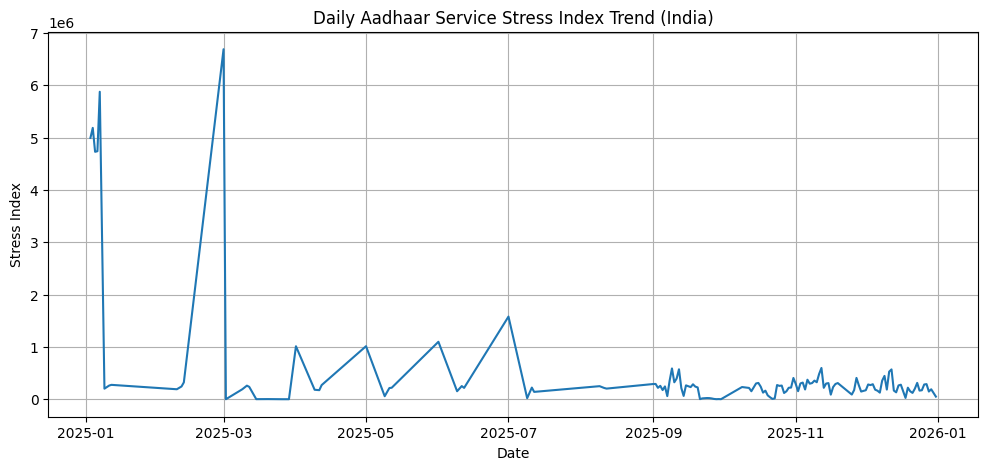

In [16]:
daily_trend = merged.groupby("date", as_index=False)["service_stress_index"].sum()

plt.figure(figsize=(12,5))
plt.plot(daily_trend["date"], daily_trend["service_stress_index"])
plt.title("Daily Aadhaar Service Stress Index Trend (India)")
plt.xlabel("Date")
plt.ylabel("Stress Index")
plt.grid(True)
plt.show()


# Top 10 District Hotspots (Bar)

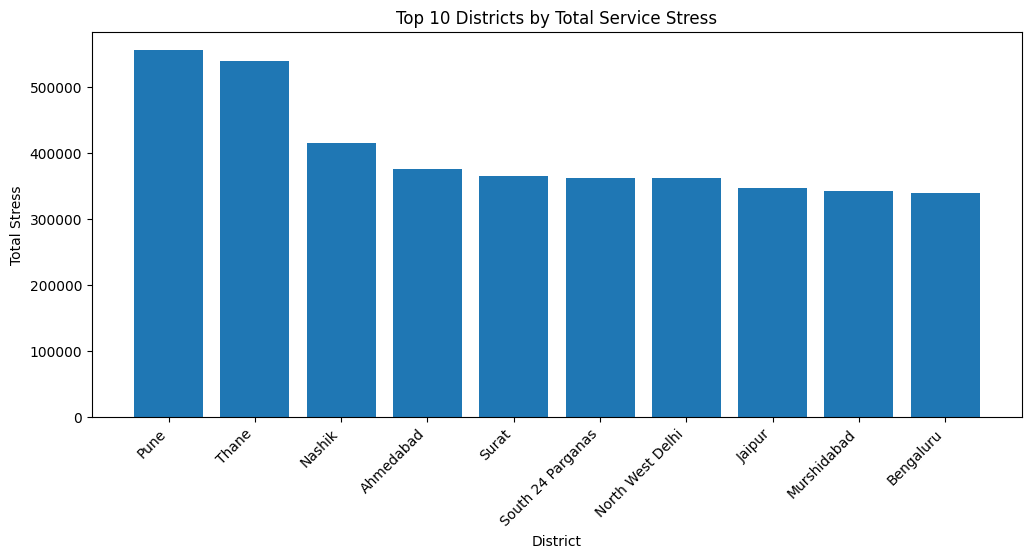

In [17]:
plt.figure(figsize=(12,5))
plt.bar(district_hotspots["district"].head(10), district_hotspots["total_stress"].head(10))
plt.title("Top 10 Districts by Total Service Stress")
plt.xlabel("District")
plt.ylabel("Total Stress")
plt.xticks(rotation=45, ha="right")
plt.show()


# Updates vs Enrolments Scatter (District Level)

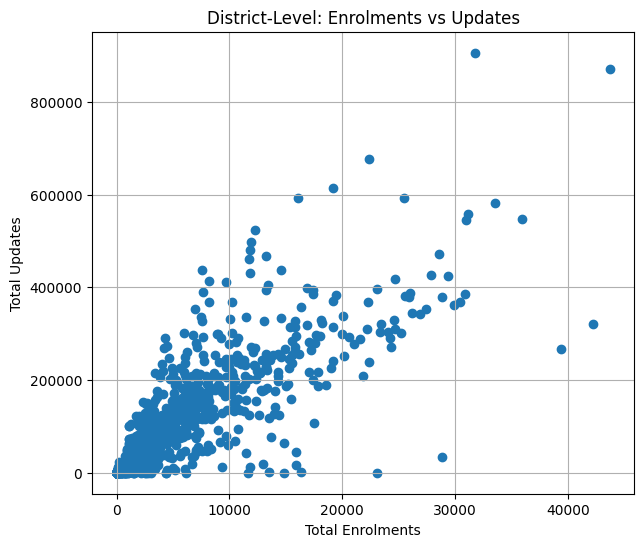

In [18]:
district_summary = (merged.groupby(["state", "district"], as_index=False)
                    .agg(
                        enrol=("total_enrolments", "sum"),
                        updates=("total_updates", "sum"),
                        stress=("service_stress_index", "sum")
                    ))

plt.figure(figsize=(7,6))
plt.scatter(district_summary["enrol"], district_summary["updates"])
plt.title("District-Level: Enrolments vs Updates")
plt.xlabel("Total Enrolments")
plt.ylabel("Total Updates")
plt.grid(True)
plt.show()


# **Export Final CSV**

In [19]:
final_path = "/content/final_uidai_service_stress.csv"
merged.to_csv(final_path, index=False)
print("Saved for Power BI:", final_path)


Saved for Power BI: /content/final_uidai_service_stress.csv
